In [1]:
#LOADING THE REQUIRED LIBRARIES
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

In [2]:
#LOADING THE TRAIN DATASET
df = pd.read_csv('train.tsv',delimiter='\t',index_col=['train_id'])
print(df.shape)
df.info()

(1482535, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482531 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB


In [3]:
# LOADING THE TEST DATASET
df_test  = pd.read_csv("test_stg2.tsv",delimiter="\t",index_col=["test_id"])
df_test

,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...
...,...,...,...,...,...,...
3460720,DARK SAMPLE BYE FOUNDATION MOISTURIZER,1,Beauty/Fragrance/Women,NaN,1,It cosmetics Bye Bye Foundation Full Coverage ...
3460721,bundle for @brandystash,2,Women/Pants/Other,NaN,1,♡2 pairs of omighty trackiez. one m and one s....
3460722,Toddler High-top Converse,3,Kids/Girls 0-24 Mos/Shoes,Nike,0,Size 5 (toddler). Pink high top converse shoes...


In [4]:
df.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
df.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

# Preprocessing of Data

## 'price'

In [6]:
'''THIS CELL CREATES NEW COLOMN WITH LOG(PRICE+1)'''
df["log_price"] = df.price.apply(lambda x:np.log(x+1))
df.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price
train_id,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662


## 'name'

In [7]:
'''THIS CELL PREPROCESSES THE NAME FEATURE'''

# Ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

st_words = stopwords.words('english')

def name_process(text):
    '''THIS FUNCTION IS USED TO PREPROCESS THE NAME FEATURE'''
    text = decontracted(text)
    text = re.sub("[^A-Za-z0-9 ]","",text) # REMOVE EVERYTHING EXCEPT THE PROVIDED CHARACTERS
    text = text.lower() # CONVERT TO LOWER CASE
    text =  " ".join([i for i in text.split() if i not in st_words])
    if len(text)==0:
        text = "missing"
    return text # RETURN THE OUTPUT TEXT


In [8]:
# APPLYING THE "preprocessing" FUNCTION ON THE FEAUTRE "name"
df["name_processed"] = df.name.apply(name_process)
df[df.name_processed.isnull()].name_processed ="missing" 

# APPLYING THE "preprocessing" FUNCTION ON THE FEAUTRE "name" on test data
df_test["name_processed"] = df_test.name.apply(name_process)
df_test[df_test.name_processed.isnull()].name_processed ="missing"

## brand_name 

In [9]:
'''CREATING PREPROCESSING FUNCTION FOR BRAND NAME'''
def brand_process(text):
    text = re.sub("[^A-Za-z0-9 ]","",text)# REMOVE EVERYTHING EXCEPT THE PROVIDED CHARACTERS
    text = text.lower()  # CONVERT TO LOWER CASE
    return text

In [10]:
# here we are assigning score correrponding to each brand_name
# the easiest way is to assign the score equals to number of occurences for that brand and store in the form of dict.
# we will use this in following code
brand_score = dict(df[df.brand_name.notnull()]["brand_name"].apply(brand_process).value_counts())

processed_brand_name = [] #storing the barand name after preprocessing
for index,i in tqdm(df.iterrows()) : # for each row in the dataset
    
    if  pd.isnull(i.brand_name): #if the brand name isnull we follow this
        
        words = i.name_processed.split() # we will split the name for that datapoint
        score  = [] # this variable stores the score for each word that we calculated above
        for j in words: # for each word 
            if j in brand_score.keys(): #if the words in name is present in the keys of brand score dict
                score.append(brand_score[j]) # take the score from the dict and append in the score variable
            else: #if the word is not a brand name append -1
                score.append(-1)
        # once we get the scores for all the words in the name the word with maximum score woulb be the brand name
        if max(score) > 0: #if the maximum score is greater than 0 then it contains a brand name so we append the brand name
            processed_brand_name.append(words[score.index(max(score))])
        else: # if maximum value is less than 0 then it means no brand name was found so "missing" is appended
            processed_brand_name.append("missing")
            
    else: # if the brand_name is not null we follow this
        processed_brand_name.append(brand_process(i.brand_name))

1482535it [04:14, 5827.04it/s]


In [11]:
'''CREATING NEW COLUMN WITH PROCESSED BRAND NAMES'''
df["brand_name_processed"] = processed_brand_name

In [12]:
'''APPLYING PROCESSING TO TEST DATASET BRAND NAME'''
processed_brand_name_test = []
for index,i in tqdm(df_test.iterrows()) :
    
    if  pd.isnull(i.brand_name):
        
        words = i.name_processed.split()
        score  = []
        for j in words:
            if j in brand_score.keys():
                score.append(brand_score[j])
            else:
                score.append(-1)
        
        if max(score) > 0:
            processed_brand_name_test.append(words[score.index(max(score))])
        else:
            processed_brand_name_test.append("missing")
    else:
        processed_brand_name_test.append(brand_process(i.brand_name))


3460725it [09:51, 5851.48it/s]


In [13]:
'''CREATING NEW COLUMN WITH PROCESSED BRAND NAMES '''
df_test["brand_name_processed"] = processed_brand_name_test

## category_name 

In [14]:
'''THIS CELL CREATES THE FUNCTION TO PREPROCESS THE  "category_name" FEATURE'''

def category_name_preprocessing(text):
    ''' THIS FUNCTION PREPROCESSES THE TEXT IN "category_name" FEATURE'''
    text = re.sub("[^A-Za-z0-9/ ]","",text)# REMOVING ALL THE TEXT EXCEPT THE GIVEN CHARACTERS
    text = re.sub("s "," ",text) # REMOVING  "s" AT THE END OF THE WORD
    text = re.sub("s/","/",text) # REMOVING  "s" AT THE END OF THE WORD
    text = re.sub("  "," ",text) # REMOVING ONE SPACE WHERE TWO SPACES ARE PRESENT
    text = text.lower() # CONVERTING THE TEXT TO LOWER CASE
    return text # RETURNING THE PROCESSED TEXT

In [15]:
'''THIS CELL REPLACE THE NULL VALUES WITH WORD "missing" AND PREPROCESSES THE category_name FEATURE '''

# HERE WE ARE REPLACING THE NULL VALUES IN "category_name" WITH WORD "missing"
df.category_name[df.category_name.isnull()] = "missing"
# HERE WE ARE PREPROCESSING THE TEXT IN "category_name"
df["category_name_preprocessed"] = df.category_name.apply(category_name_preprocessing)

In [16]:
# PREPROCESSING ON TEST DATA
df_test.category_name[df_test.category_name.isnull()] = "missing"
df_test["category_name_preprocessed"] = df_test.category_name.apply(category_name_preprocessing)

## Division of category_name

### 'Tier_1' 

In [17]:
'''THIS CELL SPLITS THE TOTAL CATEGORY NAME WITH "/" AND WHERE NULL IS PRESENT "missing" IS USED'''

# FORMING A COLUMN "Tier_1"
df["Tier_1"] = df.category_name_preprocessed.apply(lambda x:   x.split("/")[0] if len(x.split("/"))>=1 else "missing")

# PREPROCESSING ON TEST DATA
df_test["Tier_1"] = df_test.category_name_preprocessed.apply(lambda x:   x.split("/")[0] if len(x.split("/"))>=1 else "missing")

### 'Tier_2'

In [18]:
# FORMING A COLUMN "Tier_2"
df["Tier_2"] = df.category_name_preprocessed.apply(lambda x:   x.split("/")[1] if len(x.split("/"))>1 else "missing")

df_test["Tier_2"] = df_test.category_name_preprocessed.apply(lambda x:   x.split("/")[1] if len(x.split("/"))>1 else "missing")

### 'Tier_3' 

In [19]:
# FORMING A COLUMN "Tier_3"
df["Tier_3"] = df.category_name_preprocessed.apply(lambda x:   x.split("/")[2] if len(x.split("/"))>1 else "missing")

df_test["Tier_3"] = df_test.category_name_preprocessed.apply(lambda x:   x.split("/")[2] if len(x.split("/"))>1 else "missing")

## 'item_description'

In [20]:
'''PREPROCESSING FUNCTION FOR ITEM DESCRIPTION'''
def processing_item_description(text):
    '''THIS FUNCTION PREPROCESSES THE TEXT IN "item_description"'''
    text = re.sub("\[rm\] ","",str(text))
    text = decontracted(text)
    text = re.sub("[^A-Za-z0-9 ]","",str(text))
    text = str(text).lower()
    text =  " ".join([i for i in text.split() if i not in st_words])
    if len(text)==0:
        text = "missing"
    return text

In [21]:
'''REPLACING THE NULL VALUVE WITH WORD "missing" '''

df.item_description[df.item_description.isnull()]="missing"

'''HERE WE ARE PREPROCESSING THE TEXT IN FEATURE "item_description" '''

df["processed_item_description"] = df.item_description.apply(processing_item_description)

In [22]:
# PREPROCESSING FOR TEST DATA
df_test.item_description[df_test.item_description.isnull()]="missing"
df_test["processed_item_description"] = df_test.item_description.apply(processing_item_description)

# Exploratory Data Analysis

In [23]:
'''GETTING THE SHAPE OF THE DATASET'''
df.shape

(1482535, 15)

In [24]:
'''GETTING THE BASIC INFO ABOUT THE DATASET'''
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 15 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   name                        1482535 non-null  object 
 1   item_condition_id           1482535 non-null  int64  
 2   category_name               1482535 non-null  object 
 3   brand_name                  849853 non-null   object 
 4   price                       1482535 non-null  float64
 5   shipping                    1482535 non-null  int64  
 6   item_description            1482535 non-null  object 
 7   log_price                   1482535 non-null  float64
 8   name_processed              1482535 non-null  object 
 9   brand_name_processed        1482535 non-null  object 
 10  category_name_preprocessed  1482535 non-null  object 
 11  Tier_1                      1482535 non-null  object 
 12  Tier_2                      1482535 non-null  object 
 1

*Observation:*
- We can observe that out of all the features present category_name, brand_name and item_description contains some null values

# Feature Wise Analysis:

### 1. Target variable: price and log_price

In [25]:
'''BASIC STATISTICS ABOUT THE PRICE FEATURE'''
df.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

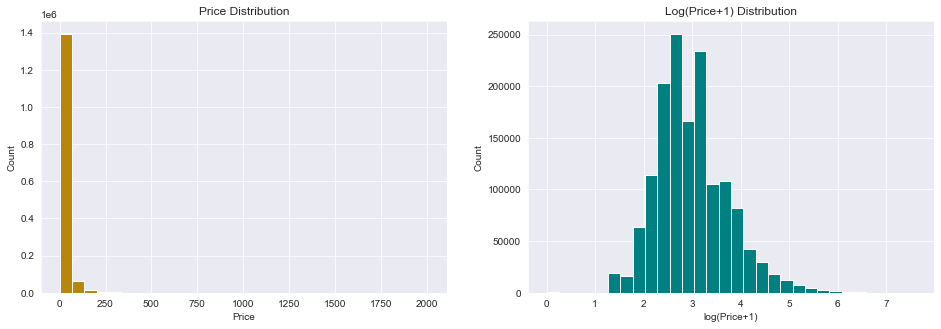

In [26]:
'''PLOTTING THE DISTRIBUTION OF PRICE AND LOG_PRICE'''

# HERE THE PDF FOR PRICE PLOTTED
sns.set_style("darkgrid")
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(df.price,bins=30,color="darkgoldenrod")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")

# HERE THE PDF FOR LOG_PRICE IS PLOTTED
plt.subplot(1,2,2)
plt.hist(df.log_price,bins=30,color="teal")
plt.title("Log(Price+1) Distribution")
plt.xlabel("log(Price+1)")
plt.ylabel("Count")
plt.show()

*Observation:*

-The distribution of the price is highly skewed.

-The log(price+1) gives a better distribution which is not exactly gaussiun but close to gaussiun.

-Log(Price+1) values will also help us in determining the loss values in better manner because our loss is "Root Mean Squared Logarithmic Error."

### item_condition_id 

Feature : item_condition_id
+----------+--------+------------+
| Category | Count  | Percent(%) |
+----------+--------+------------+
|    1     | 640549 |   43.21    |
|    3     | 432161 |   29.15    |
|    2     | 375479 |   25.33    |
|    4     | 31962  |    2.16    |
|    5     |  2384  |    0.16    |
+----------+--------+------------+


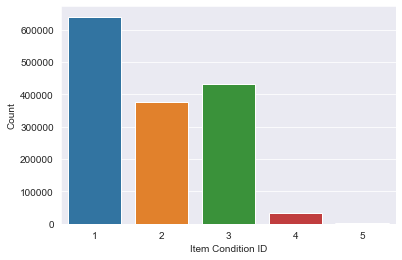

In [27]:
'''THE COUNT FOR EACH CATEGORY IN "item_condition_id" FEATURE IS DONE HERE'''

# PLOTTING A TABLE FOR CATEGORIES WITH COLUMNS WITH NAMES OF CATEGORIES , COUNT , PERCENTAGE.
x = PrettyTable()
x.add_column("Category",df.item_condition_id.value_counts().index)
x.add_column("Count",df.item_condition_id.value_counts().values)
x.add_column("Percent(%)",np.round(df.item_condition_id.value_counts().values/df.shape[0]*100,2))
print("Feature : item_condition_id")
print(x)

# HERE WE ARE PLOTTING A BAR PLOT TO SHOW THE COUNT PRESESNT WITH EACH CATEGORY IN THE FEATURE
sns.set_style("darkgrid")
sns.barplot(x =df.item_condition_id.value_counts().index,y= df.item_condition_id.value_counts().values)
plt.xlabel("Item Condition ID")
plt.ylabel("Count")
plt.show()

*Observation :*

-We can clearly observe for item_condition_id there lies the variability in the number of listings in each category. The maximum components fall under the categiry 1 where as 5 holds the minumum number of listings.

-The Mercaru help center page categorizes the Item Condition as 5 categories : 
New (1)
Like New (2)
Good (3)
Fair (4)
Poor (5)

-This makes sense because lower the number better is the quality/condition of the product and no one wants to rate their product as in bad condition

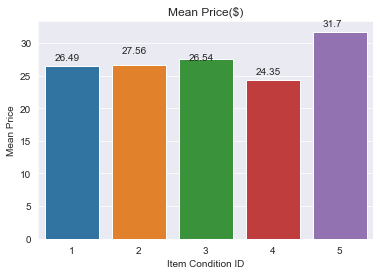

In [28]:
'''THIS CELL COMPUTES THE MEAN PRICE IN EACH CATEGORY'''

# COMPUTING THE MEACH PRICES IN EACH CATEGORY UNDER "item_condition_id" FEATURE
mean_price_condition = df[["price","item_condition_id"]].groupby(by = "item_condition_id").mean().values.reshape(-1,)

# PLOTTING THE BARPLOT FOR THE VALUES COMPUTED
g =sns.barplot(x =df.item_condition_id.value_counts().index , y=mean_price_condition)
cnt = 0
for i in mean_price_condition:
    g.text(cnt-.25,i+0.85,round(i,2))
    cnt+=1
plt.title("Mean Price($)")
plt.xlabel("Item Condition ID")
plt.ylabel("Mean Price")
plt.show()

*Observation:*

- The mean price of category 5 is higher due to less number of datapoints in this category.

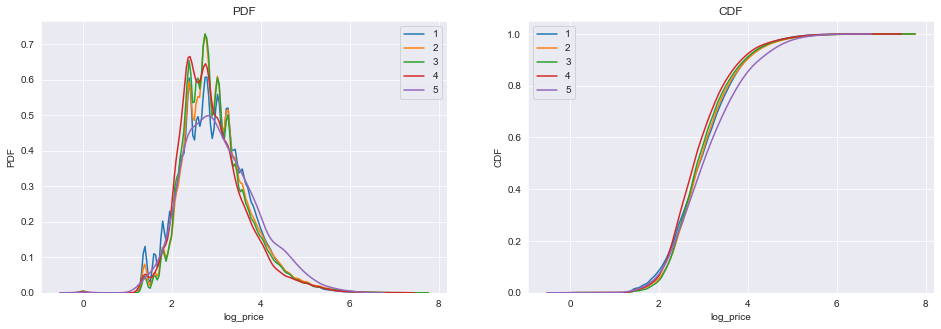

In [29]:
'''THIS CELL COMPUTES THE PDF AND CDF FOR THE PRICES IN THE EACH CATEFORY OF "item_condition_id" FEATURE'''

# THIS PLOT SHOW THE PDF FOR ALL THE PRCICES FOR DIFFERENT "item_condition_id"
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df[df.item_condition_id==1]["log_price"],hist=False,label = 1)
sns.distplot(df[df.item_condition_id==2]["log_price"],hist=False,label = 2)
sns.distplot(df[df.item_condition_id==3]["log_price"],hist=False,label = 3)
sns.distplot(df[df.item_condition_id==4]["log_price"],hist=False,label = 4)
sns.distplot(df[df.item_condition_id==5]["log_price"],hist=False,label = 5)
plt.title("PDF")
plt.ylabel("PDF")
plt.legend()


# THIS PLOT SHOW THE CDF FOR ALL THE PRCICES FOR DIFFERENT "item_condition_id"
plt.subplot(1,2,2)
sns.kdeplot(df[df.item_condition_id==1]["log_price"],cumulative=True,label = 1)
sns.kdeplot(df[df.item_condition_id==2]["log_price"],cumulative=True,label = 2)
sns.kdeplot(df[df.item_condition_id==3]["log_price"],cumulative=True,label = 3)
sns.kdeplot(df[df.item_condition_id==4]["log_price"],cumulative=True,label = 4)
sns.kdeplot(df[df.item_condition_id==5]["log_price"],cumulative=True,label = 5)
plt.title("CDF")
plt.ylabel("CDF")
plt.legend()
plt.show()

*Observation:*

- The distribution chart for each category is quite croweded and overlapping. Therefore it is difficult to draw much conclusion.
- The CDF plot for category 5 is lower than the other which makes sense because the condition of this category is Poor

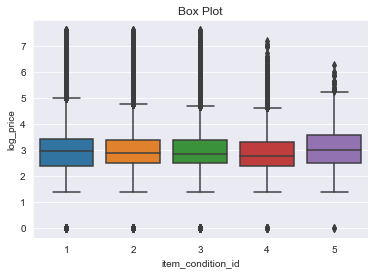

In [30]:
'''THIS CELL PLOTS THE BOX PLOT FOR DIFFERENT "item_condition_id"'''

sns.boxplot(x="item_condition_id",y="log_price",data=df)
plt.title("Box Plot")
plt.show()

*Observation:

- We can observe that the maximum values of prices is almost same for category 1 , 2 , 3 while 4 and 5 have lower range.

- The mean value of price for category 5 is slightly higher as compared to other categories.

Feature : shipping
Total number of categories = 2
+----------+--------+------------+
| Category | Count  | Percent(%) |
+----------+--------+------------+
|    0     | 819435 |   55.27    |
|    1     | 663100 |   44.73    |
+----------+--------+------------+


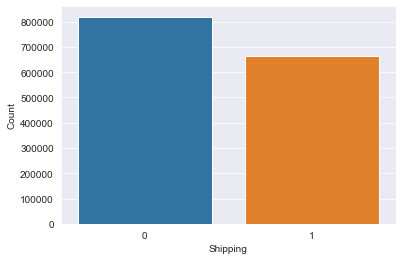

In [31]:
'''THIS CELL COMPUTES THE COUNT FOR DIFFERENT CATEGORIES OF "shipping" FEATURE'''

# HERE WE ARE TABULATING THE CATEGORIES IN "shipping",COUNT AND PERCENTAGE 
x = PrettyTable()
x.add_column("Category",df.shipping.value_counts().index)
x.add_column("Count",df.shipping.value_counts().values)
x.add_column("Percent(%)",np.round(df.shipping.value_counts().values/df.shape[0]*100,2))
print("Feature : shipping")
print("Total number of categories =",str(df.shipping.value_counts().shape[0]))
print(x)

# HERE WE ARE PLOTTING THE BARPLOT FOR COUNT AGAINST DIFFERENT CATEGORIES OF "shipping"
sns.barplot(x =df.shipping.value_counts().index,y= df.shipping.value_counts().values)
plt.xlabel("Shipping")
plt.ylabel("Count")
plt.show()


*Observation:*

- The data clearly states that for categorical features there exists an imbalance among the categories.

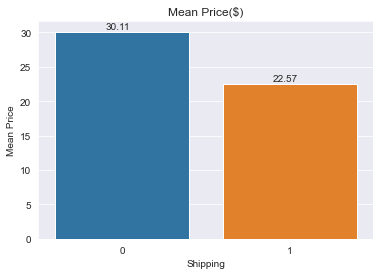

In [32]:
'''THIS CELL COMPUTES THE PDF AND CDF FOR THE PRICES IN THE EACH CATEFORY OF "shipping" FEATURE'''

# COMPUTING THE MEACH PRICES IN EACH CATEGORY UNDER "shipping" FEATURE
mean_price_shipping = df[["price","shipping"]].groupby(by = "shipping").mean().values.reshape(-1,)

# PLOTTING THE BARPLOT FOR THE VALUES COMPUTED 
g =sns.barplot(x =df.shipping.value_counts().index , y= mean_price_shipping)
# THIS PART OF CODE SHOWS THE TEXT ON THE BAR GRAPH
cnt = 0
for i in mean_price_shipping:
    g.text(cnt-0.1,i+0.4,round(i,2))
    cnt+=1
plt.xlabel("Shipping")
plt.title("Mean Price($)")
plt.ylabel("Mean Price")
plt.show()

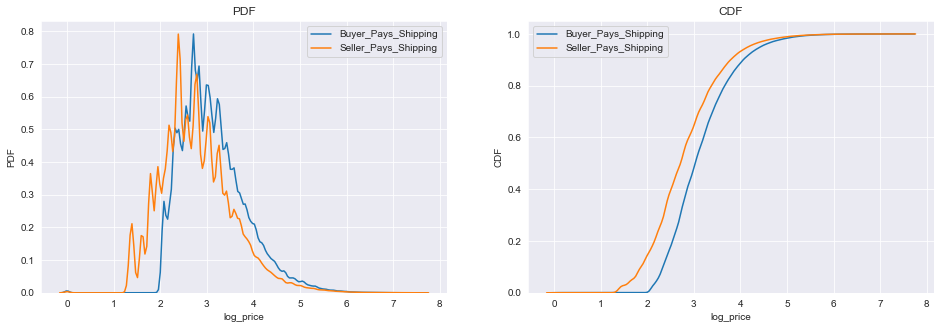

In [33]:
'''THIS CELL PLOTS THE PDF AND CDF FOR DIFFERENT CATEGORIES IN "shipping" FEATURE'''

#HERE WE ARE PLOTTING THE PDF
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df[df.shipping==0]["log_price"],hist=False,label ="Buyer_Pays_Shipping")
sns.distplot(df[df.shipping==1]["log_price"],hist=False,label="Seller_Pays_Shipping")
plt.title("PDF")
plt.ylabel("PDF")
plt.legend()

#HERE WE ARE PLOTTING THE CDF
plt.subplot(1,2,2)
sns.kdeplot(df[df.shipping==0]["log_price"],label ="Buyer_Pays_Shipping",cumulative=True)
sns.kdeplot(df[df.shipping==1]["log_price"],label="Seller_Pays_Shipping",cumulative=True)
plt.title("CDF")
plt.ylabel("CDF")
plt.legend()
plt.show()

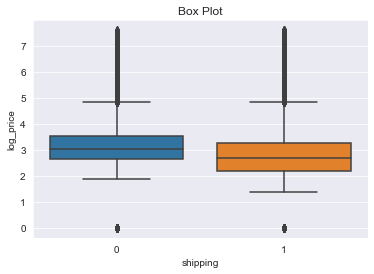

In [34]:
'''THIS CELL PLOTS THE BOX PLOT FOR CATEGORIES IN "shipping"'''

sns.boxplot(x="shipping",y="log_price",data=df)
plt.title("Box Plot")
plt.show()

*Observation:*

- There is some information in this feature because the distribution of the categories are different from eachother.
- The CDF plot for buyer pays is shifted towards right which show the prices for buyer paying the shipping is higher.
- As boxplot also states that the category 1 have lower prices than category 0. This is understood because "1" signifies that seller will pay the shipping which makes the product price lower.

*Observation:*

- The maximum occurring name is "bundle" about 3k times.

## 4. 'brand_name_processed' 

Feature : brand_name
Total number of categories = 4799
Top 10
+------------------+--------+------------+
|   Brand Names    | Count  | Percent(%) |
+------------------+--------+------------+
|     missing      | 412071 |    27.8    |
|       pink       | 69955  |    4.72    |
|     lularoe      | 61989  |    4.18    |
|       nike       | 56822  |    3.83    |
| victorias secret | 48036  |    3.24    |
|      apple       | 19460  |    1.31    |
|     nintendo     | 15934  |    1.07    |
|    forever 21    | 15186  |    1.02    |
|    lululemon     | 14980  |    1.01    |
|   michael kors   | 13928  |    0.94    |
+------------------+--------+------------+
Least 10
+-----------------------------+-------+---------+
|         Brand Names         | Count | Percent |
+-----------------------------+-------+---------+
|          john henry         |   1   |  7e-05  |
|        makeup forever       |   1   |  7e-05  |
|        anne fontaine        |   1   |  7e-05  |
|             cbk          

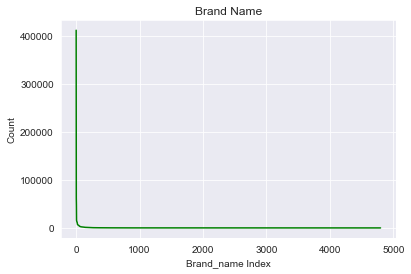

In [35]:
'''THIS CELL WE ARE PRINTING THE TOP 10 OCCURING BRAND NAMES AND LEAST 10 OCCURING BRAND NAMES'''
'''WE ARE ALSO PLOTTING THE LINE PLOT WITH FREQUENCY AGAINST THE INDEX VALUE OF BRAND NAMES'''

# THIS PART OF CODE PRINTS THE TOP 10 OCCURING BRAND NAMES
print("Feature : brand_name")
print("Total number of categories =",str(df.brand_name_processed.value_counts().shape[0]))
x =PrettyTable()
x.add_column("Brand Names",df.brand_name_processed.value_counts().index[:10])
x.add_column("Count",df.brand_name_processed.value_counts().values[:10])
x.add_column("Percent(%)",np.round(df.brand_name_processed.value_counts().values[:10]/df.shape[0]*100,2))
print("Top 10")
print(x)

# THIS PART OF CODE PRINTS THE LEAST 10 OCCURING BRAND NAMES
x =PrettyTable()
x.add_column("Brand Names",df.brand_name_processed.value_counts().index[-10:])
x.add_column("Count",df.brand_name_processed.value_counts().values[-10:])
x.add_column("Percent",np.round(df.brand_name_processed.value_counts().values[-10:]/df.shape[0]*100,5))
print("Least 10")
print(x)

# THIS PART OF CODE PLOTS THE LINE PLOT OF FREQUENCY AGAINST THE INDEX VALUE BRAND NAMES
sns.lineplot(x =range(len(df.brand_name_processed.value_counts().values)),y=df.brand_name_processed.value_counts().values,color='g')
plt.title("Brand Name")
plt.xlabel("Brand_name Index")
plt.ylabel("Count")
plt.show()

*Observation:*

- The brand that occurs maximum number of times is 'pink' over 69k times.

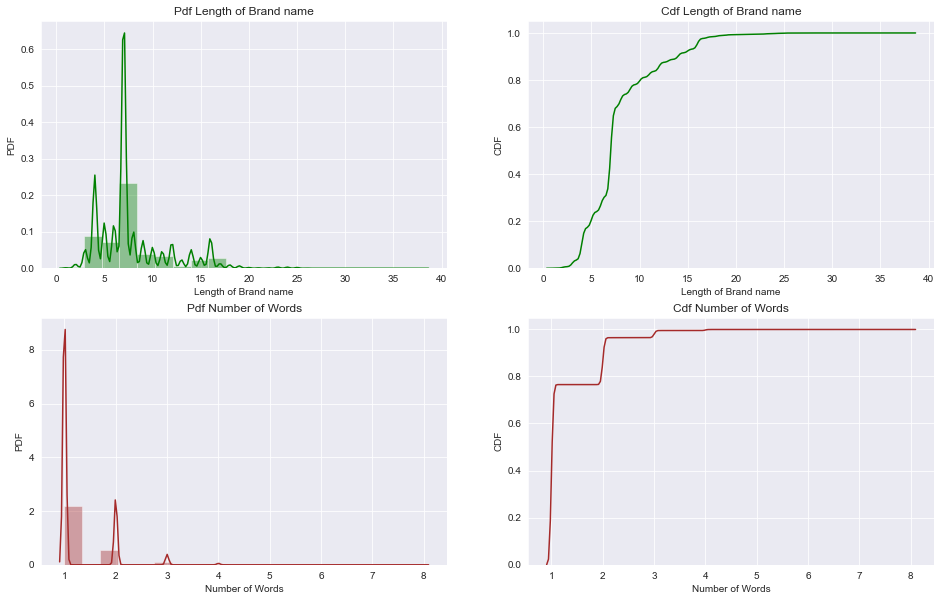

In [36]:
'''THIS CELL PLOTS THE PDF AND CDF OF THE LENGHT OF CHARATERS AND NUMBER OF WORDS IN BRAND NAME'''

# THIS PART OF CODE PLOTS THE PDF OF THE LENTH OF BRAND NAME 
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
sns.set_style("darkgrid")
sns.distplot(df.brand_name_processed.apply(len),color="green",bins=20)
plt.title("Pdf Length of Brand name")
plt.xlabel("Length of Brand name")
plt.ylabel("PDF")

# THIS PART OF CODE PLOTS THE CDF OF THE LENGTH OF BRAND NAME
plt.subplot(2,2,2)
sns.kdeplot(df.brand_name_processed.apply(len),color="green",cumulative=True)
plt.title("Cdf Length of Brand name")
plt.xlabel("Length of Brand name")
plt.ylabel("CDF")

# THIS PART OF CODE PLOTS THE PDF OF NUMBER OF WORDS IN BRAND NAME
plt.subplot(2,2,3)
sns.distplot(df.brand_name_processed.apply(lambda x: len(x.split())),color="brown",bins=20)
plt.title("Pdf Number of Words")
plt.xlabel("Number of Words")
plt.ylabel("PDF")

# THIS PART OF CODE PLOTS THE CDF OF NUMBER OF WORDS IN BRAND NAME
plt.subplot(2,2,4)
sns.kdeplot(df.brand_name_processed.apply(lambda x: len(x.split())),color="brown",cumulative=True)
plt.xlabel("Number of Words")
plt.title("Cdf Number of Words")
plt.ylabel("CDF")
plt.show()

*Observation:*

- Majority of brand names are of one word.

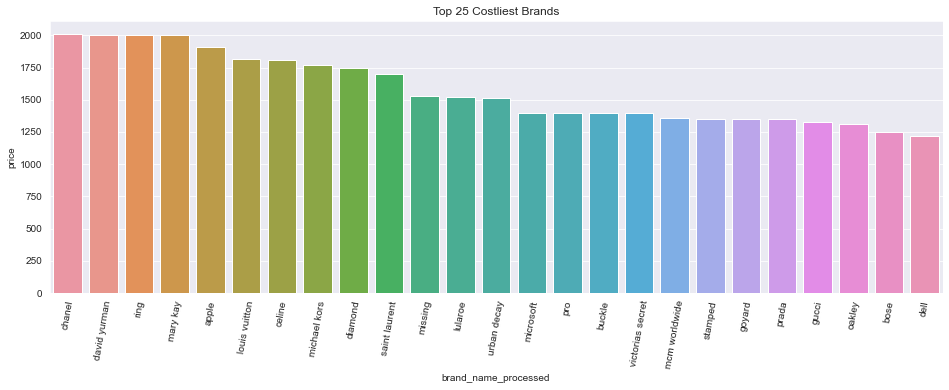

In [37]:
'''BAR PLOT FOR TOP 25 COSTLIEST BRAND AGAINST THEIR PRICE'''
df_brand_group = df[["brand_name_processed","price"]].groupby(by="brand_name_processed" ).max()
df_brand_group = df_brand_group.sort_values(by="price",ascending=False)

plt.figure(figsize=(16,5))
sns.barplot(x=df_brand_group.index[:25],y= df_brand_group.price[:25])
plt.title("Top 25 Costliest Brands")
plt.xticks(rotation=80)
plt.show()

*Observation:*

- The maximum price for top brand is almost touches 2000 dollars.
- It also depends on the product type as there is a brand ring which would most probably be selling rings. This product in its own is a costly product irrespective of the brand

Feature : category_name
Total number of categories = 1287
Top 10
+---------------------------------------------------+-------+------------+
|                   Category Names                  | Count | Percent(%) |
+---------------------------------------------------+-------+------------+
|     women/athletic apparel/pant tight leggings    | 60177 |    4.06    |
|              women/top blouse/tshirts             | 46380 |    3.13    |
|                 beauty/makeup/face                | 34335 |    2.32    |
|                 beauty/makeup/lips                | 29910 |    2.02    |
|        electronic/video game console/games        | 26557 |    1.79    |
|                 beauty/makeup/eyes                | 25215 |    1.7     |
| electronic/cell phone accessorie/case cover skins | 24676 |    1.66    |
|                women/underwear/bras               | 21274 |    1.43    |
|              women/top blouse/blouse              | 20284 |    1.37    |
|             women/top blouse/tank

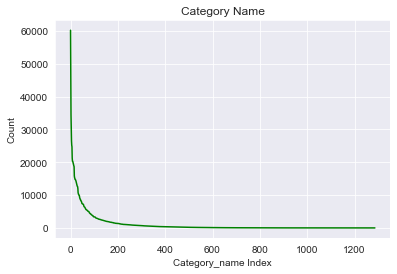

In [38]:
'''THIS CELL PRINTS THE NUMBER OF CATEGORIES IN "category_name" FEATURE.
    THIS ALSO PRINTS THE TABLE FOR 10 MOST FEQUENT CATEGORIES IN THE FEATURE AND 10 LEAST OCCURING FEATURES WITH A LINE PLOT OF 
    COUNT AND INDEX OF CATEGORIES IN "category_name" '''

# HERE WE ARE PRINTING THE NUMBER OF CATEGORIES IN THE "category_name" FEATURE. 
print("Feature : category_name")
print("Total number of categories =",str(df.category_name_preprocessed.value_counts().shape[0]))

# HERE WE ARE PRINTING THE TABLE FOR 10 MOST OCCURING catagory_names
x =PrettyTable()
x.add_column("Category Names",df.category_name_preprocessed.value_counts().index[:10])
x.add_column("Count",df.category_name_preprocessed.value_counts().values[:10])
x.add_column("Percent(%)",np.round(df.category_name_preprocessed.value_counts().values[:10]/df.shape[0]*100,2))
print("Top 10")
print(x)

# HERE WE ARE PRITING THE TABLE FOR 10 LEAST OCCURING category_name
x =PrettyTable()
x.add_column("Category Names",df.category_name_preprocessed.value_counts().index[-10:])
x.add_column("Count",df.category_name_preprocessed.value_counts().values[-10:])
x.add_column("Percent(%)",np.round(df.category_name_preprocessed.value_counts().values[-10:]/df.shape[0]*100,5))
print("Least 10")
print(x)

# HERE WE ARE PLOTTING THE LINE PLOT FOR FREQUENCY OF CATEGORIES IN category_name AND INDEX OF category_names.
sns.set_style("darkgrid")
sns.lineplot(x =range(len(df.category_name_preprocessed.value_counts())),y=df.category_name_preprocessed.value_counts().values,color='g')
plt.title("Category Name")
plt.xlabel("Category_name Index")
plt.ylabel("Count")
plt.show()

*Observations :*

- There are total of 1200 categories in category name feature.

- In top 10 categories majority of product are for women.

- From the Mercari Website we can observe that the product categories are heirarchical and have three levels which can also be observed in the data as the categories are divided by "/

## 'Tier_1' 

Feature : Category_name/Tier_1
Total number of categories = 11
+---------------------+--------+------------+
|        Tier_1       | Count  | Percent(%) |
+---------------------+--------+------------+
|        women        | 664385 |   44.81    |
|        beauty       | 207828 |   14.02    |
|         kid         | 171689 |   11.58    |
|      electronic     | 122690 |    8.28    |
|         men         | 93680  |    6.32    |
|         home        | 67871  |    4.58    |
| vintage collectible | 46530  |    3.14    |
|        other        | 45351  |    3.06    |
|       handmade      | 30842  |    2.08    |
|    sport outdoor    | 25342  |    1.71    |
|       missing       |  6327  |    0.43    |
+---------------------+--------+------------+


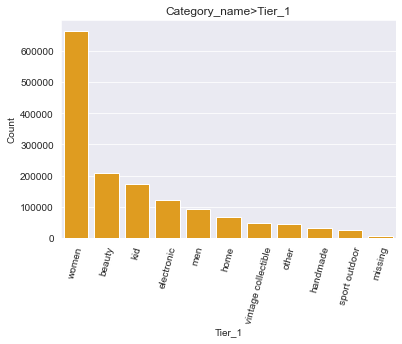

In [39]:
'''THIS CELL PRINTS THE THE NUMBER OF CATEGORIES IN "Tier_1" COLUMN AND TABULATES THE COUNT OF DATAPOINTS IN EACH CATEGORY.
    THIS ALSO PLOTS THE BARPLOT WITH NUMBER OF COUNT VERSUS CATEGORY IN "Tier_1" '''

# HERE WE ARE FORMING THE TABLE WITH CATEGORY,COUNT AND PERCENTAGE OF THE COUNT
x = PrettyTable()
x.add_column("Tier_1",df.Tier_1.value_counts().index)
x.add_column("Count",df.Tier_1.value_counts().values)
x.add_column("Percent(%)",np.round(df.Tier_1.value_counts().values/df.shape[0]*100,2))

print("Feature : Category_name/Tier_1") # PRINTING THE FEATURE NAME
print("Total number of categories =",str(df.Tier_1.value_counts().shape[0])) #PRINTING THE NUMBER OF CATEGORIES IN THE FEATURE
print(x) # PRINTING THE TABEL

# PLOTTING THE BARPLOT WITH THE COUNT VERSUS CATEGORIES IN "Tier_1"
sns.barplot(x =df.Tier_1.value_counts().index,y= df.Tier_1.value_counts().values,color="orange")
plt.title("Category_name>Tier_1")
plt.xlabel("Tier_1")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.show()


Observation:

- There are total 10 sections in Tier_1 and some are missing values.
- Almost half of the products fall under the category of "women"

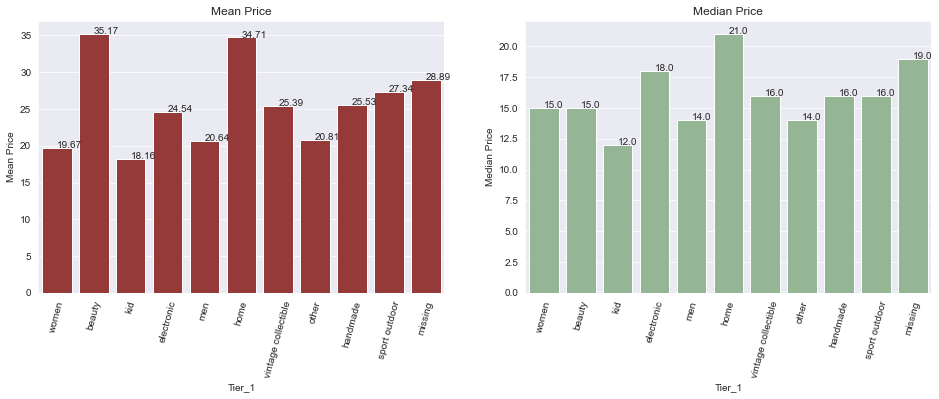

In [40]:
'''THIS CELL PLOTS THE MEAN AND MEDIAN VALUES OF PRICE FOR EACH CATEGORY IN Tiea_1'''

# COMPUTING THE MEAN FOR THE DIFFERENT CATEGORIES IN Tier_1
mean_price_tier1 = df[["price","Tier_1"]].groupby(by = "Tier_1").mean().values.reshape(-1,)
# COMOUTING THE MEDIAN FOR THE DIFFERENT CATEGORIES IN Tier_1
median_price_tier1 = df[["price","Tier_1"]].groupby(by = "Tier_1").median().values.reshape(-1,)

# THIS PART OF CODE PLOTS THE BARPLOT OF MEAN PRICE FOR EACH CATEGORY IN Tier_1
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
g =sns.barplot(x =df.Tier_1.value_counts().index , y= mean_price_tier1,color="brown")
cnt = 0
for i in mean_price_tier1:
    g.text(cnt,i,round(i,2))
    cnt+=1
plt.title("Mean Price")
plt.xlabel("Tier_1")
plt.ylabel("Mean Price")
plt.xticks(rotation=75)

# THIS PART OF CODE PLOTS THE BARPLOT OF MEDIAN OF PRICE FOR EACH CATEGORY IN Tier_1
plt.subplot(1,2,2)
g =sns.barplot(x =df.Tier_1.value_counts().index , y= median_price_tier1,color="darkseagreen")
cnt = 0
for i in median_price_tier1:
    g.text(cnt,i,round(i,2))
    cnt+=1
    plt.title("Median Price")
plt.xlabel("Tier_1")
plt.ylabel("Median Price")
plt.xticks(rotation=75)
plt.show()

*Observation:*

- The median value of category "beauty" is significantly less than the mean for the same category. This shows the price distribution plot for "beauty" is Right Skewed.Same is true for other categories that follows the same trend.

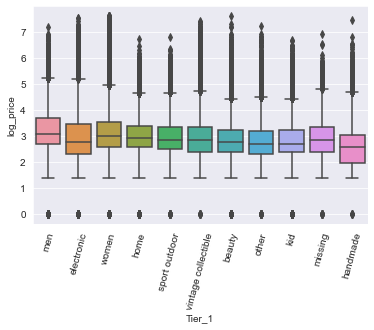

In [41]:
'''THIS CELL PLOTS THE BOXPLOT FOR PRICES IN EACH CATEGORY IN Tier_1'''

sns.boxplot(x="Tier_1",y="log_price",data=df)
plt.xticks(rotation=75)
plt.show()

#### *Observation:*

- The box plot tells that the price range for "women" and "electrinic" sections are maximum.
- "handmade" section has lower price ranges as compared to others.

## 'Tier_2'

Feature : category_name/Tier_2
Total number of categories = 111
Top 10
+-----------------------+--------+---------------+
|         Tier_2        | Count  | Percentage(%) |
+-----------------------+--------+---------------+
|    athletic apparel   | 134383 |      9.06     |
|         makeup        | 124624 |      8.41     |
|       top blouse      | 106960 |      7.21     |
|          shoe         | 100452 |      6.78     |
|          toy          | 65498  |      4.42     |
|        jewelry        | 61763  |      4.17     |
| cell phone accessorie | 53290  |      3.59     |
|     women handbag     | 45862  |      3.09     |
|         dresse        | 45758  |      3.09     |
|    women accessorie   | 42350  |      2.86     |
+-----------------------+--------+---------------+
Least 10
+---------------------+-------+---------------+
|        Tier_2       | Count | Percentage(%) |
+---------------------+-------+---------------+
|    potty training   |  155  |    0.01046    |
|     woodwork

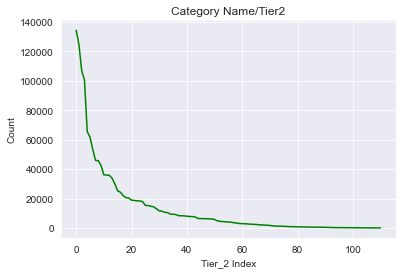

In [42]:
'''THIS CELL PRINTS THE NUMBER OF CATEGORIES IN Tier_2 WITH THE 
    TABLE CONTAINING 10 MOST FREQUENT FEATURES AND 10 LEAST FREQUENT FEATURES.
    THIS ALSO PLOTS LINEPLOT OF COUNT AND INDEX OF CATEGORIES IN "Tier_2" '''

# HERE WE ARE PRINTING THE TOTALL NUMBER OF CATEGORIES IN Tier_2
print("Feature : category_name/Tier_2")
print("Total number of categories =",str(df.Tier_2.value_counts().shape[0]))

# HERE WE ARE PRINTING THE TABLE FOR 10 MOST OCCURING Tier_2
x =PrettyTable()
x.add_column("Tier_2",df.Tier_2.value_counts().index[:10])
x.add_column("Count",df.Tier_2.value_counts().values[:10])
x.add_column("Percentage(%)",np.round(df.Tier_2.value_counts().values[:10]/df.shape[0]*100,2))
print("Top 10")
print(x)

# HERE WE ARE PRITING THE TABLE FOR 10 LEAST OCCURING Tier_2
x =PrettyTable()
x.add_column("Tier_2",df.Tier_2.value_counts().index[-10:])
x.add_column("Count",df.Tier_2.value_counts().values[-10:])
x.add_column("Percentage(%)",np.round(df.Tier_2.value_counts().values[-10:]/df.shape[0]*100,5))
print("Least 10")
print(x)

# HERE WE ARE PLOTTING THE LINE PLOT FOR FREQUENCY OF CATEGORIES IN Tier_2 AND INDEX OF Tier_2.
sns.set_style("darkgrid")
sns.lineplot(x =range(len(df.Tier_2.value_counts())),y=df.Tier_2.value_counts().values,color='g')
plt.title("Category Name/Tier2")
plt.xlabel("Tier_2 Index")
plt.ylabel("Count")
plt.show()

*Observation:

- There are more than 100 categories in this section.
- Maximum products fall under the category of "athletic apparel" whichis 9% of total data points and minimum are under "quilt".

## 9. 'Tier_3'

Feature : category_name/Tier_3
Total number of categories = 866
Top 10
+---------------------+-------+---------------+
|        Tier_3       | Count | Percentage(%) |
+---------------------+-------+---------------+
|       tshirts       | 61488 |      4.15     |
| pant tight leggings | 60177 |      4.06     |
|        other        | 50224 |      3.39     |
|         face        | 50171 |      3.38     |
|        shoes        | 32168 |      2.17     |
|        games        | 30906 |      2.08     |
|         lips        | 30871 |      2.08     |
|       athletic      | 27059 |      1.83     |
|         eyes        | 26038 |      1.76     |
|   case cover skins  | 24676 |      1.66     |
+---------------------+-------+---------------+
Least 10
+--------------------+-------+---------------+
|       Tier_3       | Count | Percentage(%) |
+--------------------+-------+---------------+
|     primitive      |   1   |     7e-05     |
|   entertainment    |   1   |     7e-05     |
|       frame

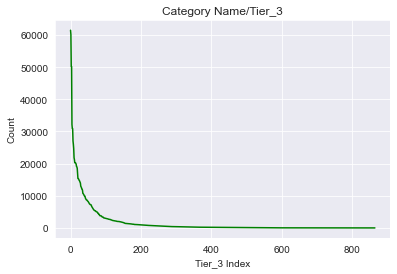

In [43]:

'''THIS CELL PRINTS THE NUMBER OF CATEGORIES IN Tier_3 WITH THE 
    TABLE CONTAINING 10 MOST FREQUENT FEATURES AND 10 LEAST FREQUENT FEATURES.
    THIS ALSO PLOTS LINEPLOT OF COUNT AND INDEX OF CATEGORIES IN "Tier_3" '''

# HERE WE ARE PRINTING THE TOTALL NUMBER OF CATEGORIES IN Tier_2
print("Feature : category_name/Tier_3")
print("Total number of categories =",str(df.Tier_3.value_counts().shape[0]))

# HERE WE ARE PRINTING THE TABLE FOR 10 MOST OCCURING Tier_2
x =PrettyTable()
x.add_column("Tier_3",df.Tier_3.value_counts().index[:10])
x.add_column("Count",df.Tier_3.value_counts().values[:10])
x.add_column("Percentage(%)",np.round(df.Tier_3.value_counts().values[:10]/df.shape[0]*100,2))
print("Top 10")
print(x)


# HERE WE ARE PRITING THE TABLE FOR 10 LEAST OCCURING Tier_2
x =PrettyTable()
x.add_column("Tier_3",df.Tier_3.value_counts().index[-10:])
x.add_column("Count",df.Tier_3.value_counts().values[-10:])
x.add_column("Percentage(%)",np.round(df.Tier_3.value_counts().values[-10:]/df.shape[0]*100,5))
print("Least 10")
print(x)

# HERE WE ARE PLOTTING THE LINE PLOT FOR FREQUENCY OF CATEGORIES IN Tier_2 AND INDEX OF Tier_2.
sns.set_style("darkgrid")
sns.lineplot(x =range(len(df.Tier_3.value_counts())),y=df.Tier_3.value_counts().values,color='g')
plt.title("Category Name/Tier_3")
plt.xlabel("Tier_3 Index")
plt.ylabel("Count")
plt.show()

**Observation:**

In third tier the maximum products are "tshirts" and "pant tight leggings"

## name_processed

Feature : name
Total number of categories = 1101891
Top 10
+----------------------+-------+------------+
|        Names         | Count | Percent(%) |
+----------------------+-------+------------+
|        bundle        |  3436 |    0.23    |
| lularoe tc leggings  |  1141 |    0.08    |
|         hold         |  1007 |    0.07    |
|       reserved       |  940  |    0.06    |
| lularoe os leggings  |  910  |    0.06    |
|     coach purse      |  712  |    0.05    |
|      miss jeans      |  695  |    0.05    |
| american eagle jeans |  681  |    0.05    |
| victoria secret bra  |  678  |    0.05    |
|  michael kors purse  |  572  |    0.04    |
+----------------------+-------+------------+
Least 10
+------------------------------------+-------+------------+
|               Names                | Count | Percent(%) |
+------------------------------------+-------+------------+
| hunter flame romilly flats size 9  |   1   |   7e-05    |
|      os lularoe leggings hold      |   1   |  

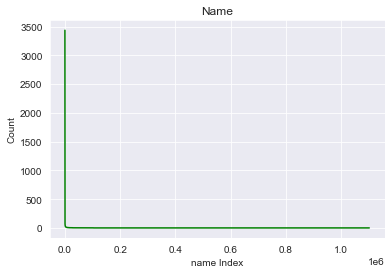

In [44]:
# THIS PART OF CODE PRINTS THE TOP 10 MOST FREQUENT NAMES 
print("Feature : name")
print("Total number of categories =",str(df.name_processed.value_counts().shape[0]))
x =PrettyTable()
x.add_column("Names",df.name_processed.value_counts().index[:10])
x.add_column("Count",df.name_processed.value_counts().values[:10])
x.add_column("Percent(%)",np.round(df.name_processed.value_counts().values[:10]/df.shape[0]*100,2))
print("Top 10")
print(x)

# THIS PART OF CODE PRINTS THE LEAST 10 FREQUENT NAMES
x =PrettyTable()
x.add_column("Names",df.name_processed.value_counts().index[-10:])
x.add_column("Count",df.name_processed.value_counts().values[-10:])
x.add_column("Percent(%)",np.round(df.name_processed.value_counts().values[-10:]/df.shape[0]*100,5))
print("Least 10")
print(x)

# THIS PART OF CODE PLOTS THE THE FREQUENCY OF THE NAMES AGAINGST THE INDEX OF THE DIFFERENT NAMES
sns.lineplot(x =range(len(df.name_processed.value_counts().values)),y=df.name_processed.value_counts().values,color='g')
plt.title("Name")
plt.xlabel("name Index")
plt.ylabel("Count")
plt.show()

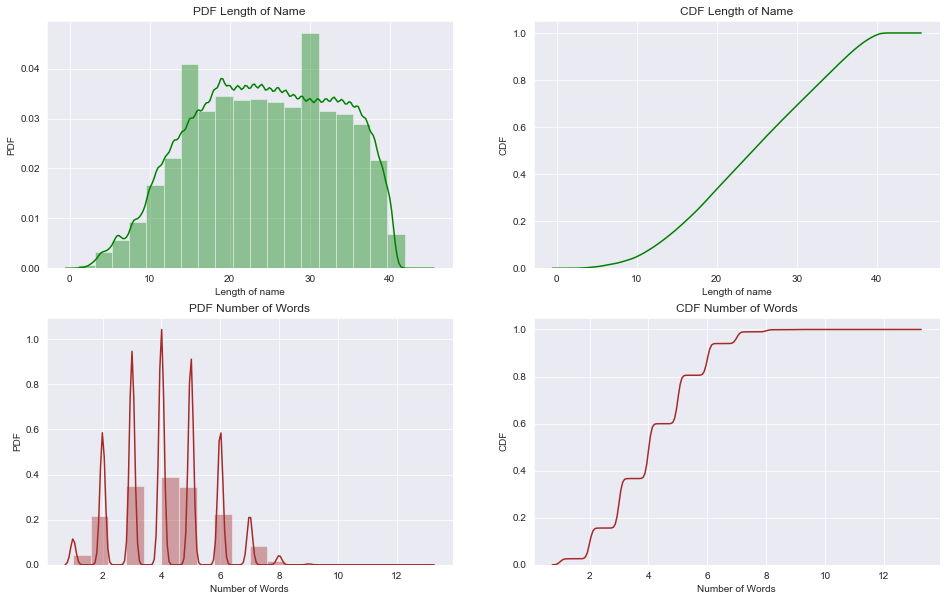

In [45]:
'''THIS CELL PLOTS THE PDF AND CDF FOR THE LENGH OF CHARACTERS AND NUMBER OF WORDS IN "name" FEATURE'''
# THIS PART OF CODE PLOTS THE PDF OF LENGTH OF CHARACTERS IN name
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
sns.set_style("darkgrid")
sns.distplot(df.name_processed.apply(len),color="green",bins=20)
plt.title("PDF Length of Name")
plt.xlabel("Length of name")
plt.ylabel("PDF")

# THIS PART OF CODE PLOT THE CDF OF LENGTH OF CHARACTERS IN name
plt.subplot(2,2,2)
sns.kdeplot(df.name_processed.apply(len),color="green",cumulative=True)
plt.title("CDF Length of Name")
plt.xlabel("Length of name")
plt.ylabel("CDF")

# THIS PART OF CODE PLOT THE PDF OF NUMBER OF WORDS IN name
plt.subplot(2,2,3)
sns.distplot(df.name_processed.apply(lambda x: len(x.split())),color="brown",bins=20)
plt.title("PDF Number of Words")
plt.xlabel("Number of Words")
plt.ylabel("PDF")

# THIS PART OF CODE PLOT THE CDF OF NUMBER OF WORDS IN name
plt.subplot(2,2,4)
sns.kdeplot(df.name_processed.apply(lambda x: len(x.split())),color="brown",cumulative=True)
plt.title("CDF Number of Words")
plt.xlabel("Number of Words")
plt.ylabel("CDF")
plt.show()

**Observation:**

- The majority of sellers tend to give more than 20 chanracters in names as the distribution of number of characters is left skewed.
- There are some sellers who give exceptionally higher words for names i.e. more than 15.

### PREPROCESSING FOR WORD CLOUD

In [46]:
'''THIS CELL JOINS ALL THE NAMES OF SPECIFIC ITEM CONDITON TOGETHER'''
# PLACEHOLDERS
id_1=""
id_2=""
id_3=""
id_4=""
id_5=""
# FOR EACH ROW IN DATASET
for index ,i in tqdm(df[["name_processed","item_condition_id"]].iterrows()):
    # JOIN THE STRIG TO SPECIFIC ITEM CONDITION ID
    if i.item_condition_id==1:
        id_1+= i.name_processed
    if i.item_condition_id==2:
        id_2+= i.name_processed
    if i.item_condition_id==3:
        id_3+= i.name_processed
    if i.item_condition_id==4:
        id_4+= i.name_processed
    if i.item_condition_id==5:
        id_5+= i.name_processed

1482535it [07:09, 3455.63it/s]


In [47]:
# STORING THE STOPWORDS IN A VARIABLE
stopword = stopwords.words('english')

#FORMING WORDCLOUDS
wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_1)
wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_2)
wordcloud3 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_3)
wordcloud4 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_4)
wordcloud5 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_5)

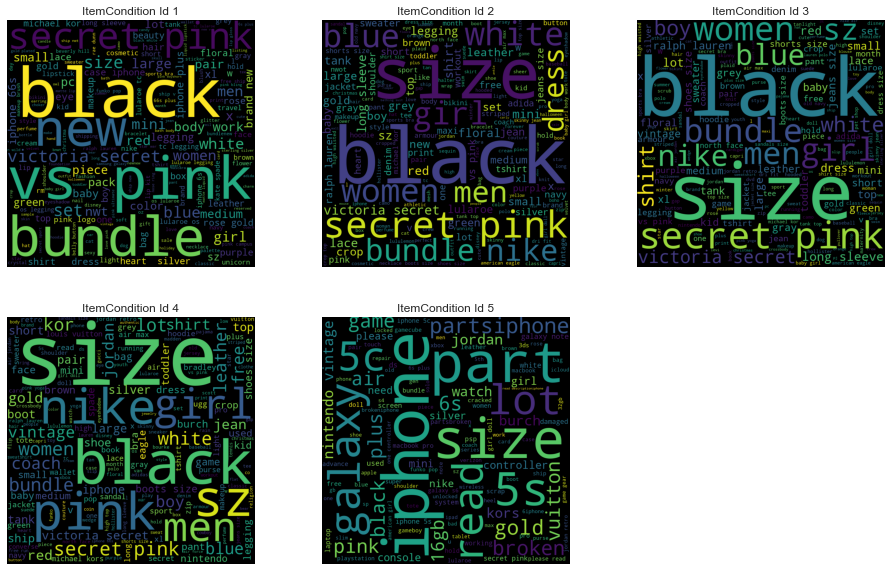

In [48]:
'''THIS CELL PLOTS THE WORD CLOUDS'''

# WORDCLOUD FOR NAMES IN ITEM CONDITION ID 1 
plt.figure(figsize = (16, 10))
plt.subplot(2,3,1)
plt.imshow(wordcloud1)
plt.title("ItemCondition Id 1")
plt.axis("off")

# WORDCLOUD FOR NAMES IN ITEM CONDITION ID 2 
plt.subplot(2,3,2)
plt.imshow(wordcloud2)
plt.title("ItemCondition Id 2")
plt.axis("off")

# WORDCLOUD FOR NAMES IN ITEM CONDITION ID 3 
plt.subplot(2,3,3)
plt.imshow(wordcloud3)
plt.title("ItemCondition Id 3")
plt.axis("off")

# WORDCLOUD FOR NAMES IN ITEM CONDITION ID 4
plt.subplot(2,3,4)
plt.imshow(wordcloud4)
plt.title("ItemCondition Id 4")
plt.axis("off")

# WORDCLOUD FOR NAMES IN ITEM CONDITION ID 5 
plt.subplot(2,3,5)
plt.imshow(wordcloud5)
plt.title("ItemCondition Id 5")
plt.axis("off")

plt.show()

**Observations :**

- Mostly the brand names are visible in the word cloud.
- As there is no size feature seperately size is mentionen in the name itself. Hence we can se size in almost all the word clouds.
- Clothing products and brands are visible in all the images."Pink" is present in all categories.
- In item conditiom 5 the "Iphone" is visible.
- In item_condition_5 word "broken" is seen which makes sense because this category is for poor qualiaty products.

## 10. item_description

In [49]:
'''THIS CELL PRINTS THE TOP 10 MOST FREQUENT ITEM DESCRIPTIONS AND THEIR COUNT AND PERCENTAGE'''

# PRINTING THE FEATURE NAME
print("Feature :item_description ")
#PRINTING THE NUMBER OF CATEGORIES
print("Total number of categories =",str(df.processed_item_description.value_counts().shape[0]))

# FORMING THE TABLE WITH TOP 10 MOST FREQUENT ITEM DESCRIPTIONS AND THEIR COUNT AND PERCENTAGE
x =PrettyTable()
x.add_column("item_description",df.processed_item_description.value_counts().index[:10])
x.add_column("Count",df.processed_item_description.value_counts().values[:10])
x.add_column("Percentage(%)",np.round(df.processed_item_description.value_counts().values[:10]/df.shape[0]*100,2))
print("Top 10")
print(x) # PRINTING THE TABLE

Feature :item_description 
Total number of categories = 1245000
Top 10
+------------------+-------+---------------+
| item_description | Count | Percentage(%) |
+------------------+-------+---------------+
| description yet  | 82499 |      5.56     |
|    brand new     |  5216 |      0.35     |
|       new        |  5079 |      0.34     |
|  good condition  |  2679 |      0.18     |
| great condition  |  2412 |      0.16     |
|    never worn    |  1568 |      0.11     |
|     like new     |  1457 |      0.1      |
|       nwt        |  1340 |      0.09     |
|       worn       |  1205 |      0.08     |
|    never used    |  1168 |      0.08     |
+------------------+-------+---------------+


**Observation:**

Around 90 percent of item descriptions are have length lower than 400

### World cloud analysis for item description

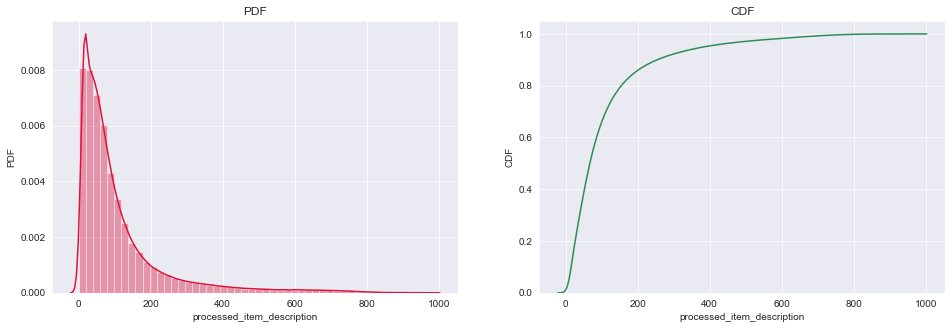

In [50]:
'''THIS CELL PLOTS THE PDF AND CDF FOR THE LENGTH OF item_description'''

# PLOTING THE PDF OF LENGTH OF ITEM_DESCRIPTION
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df.processed_item_description.apply(lambda x:len(str(x))),color="crimson")
plt.ylabel("PDF")
plt.title("PDF")

# PLOTTING THE CDF OF LENGTH OF ITEM_DESCRIPTION
plt.subplot(1,2,2)
sns.kdeplot(df.processed_item_description.apply(lambda x:len(str(x))),cumulative=True,color="seagreen")
plt.ylabel("CDF")
plt.title("CDF")
plt.show()

In [51]:
'''THIS CELL JOINS ALL THE ITEM DESCRIPTION OF SPECIFIC ITEM CONDITON TOGETHER'''

# PLACEHOLDER 
id_1_desc=""
id_2_desc=""
id_3_desc=""
id_4_desc=""
id_5_desc=""
# FOR EACH POINTS IN THE DATASET
for index ,i in tqdm(df[["processed_item_description","item_condition_id"]].iterrows()):
    # JOINGING THE SRTING BASED ON ITEM CONDITON ID
    if i.item_condition_id==1:
        id_1_desc += i.processed_item_description
    if i.item_condition_id==2:
        id_2_desc  += i.processed_item_description
    if i.item_condition_id==3:
        id_3_desc  += i.processed_item_description
    if i.item_condition_id==4:
        id_4_desc  += i.processed_item_description
    if i.item_condition_id==5:
        id_5_desc  += i.processed_item_description
    

1482535it [33:43, 732.72it/s]


In [52]:
'''FORMING THE WORD CLOUDS'''

wordcloud1_desc = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_1_desc)
wordcloud2_desc = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_2_desc)
wordcloud3_desc = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_3_desc)
wordcloud4_desc = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_4_desc)
wordcloud5_desc = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10).generate(id_5_desc)

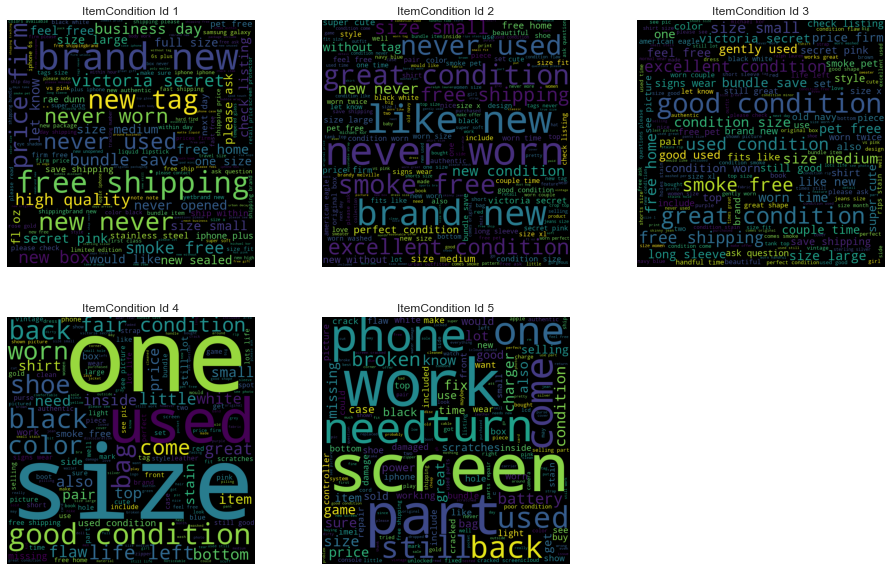

In [53]:
'''PLOTTING THE WORD CLOUD'''

plt.figure(figsize = (16, 10))

plt.subplot(2,3,1)
plt.imshow(wordcloud1_desc)
plt.title("ItemCondition Id 1")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(wordcloud2_desc)
plt.title("ItemCondition Id 2")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(wordcloud3_desc)
plt.title("ItemCondition Id 3")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(wordcloud4_desc)
plt.title("ItemCondition Id 4")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(wordcloud5_desc)
plt.title("ItemCondition Id 5")
plt.axis("off")

plt.show()

**Observaions:**
- **Item_condition_id 1**: In this category the words that occur the most are
 - brand new
 - never used
 - new
 - high quality
    Here products would be in their best condition or unique, hence these words make sense.

- **Item_condition_id 2**: In this category the words that occur the most are

 - brand new
 - like new
 - never worn
 - great condition
 - excellent condition

- **Item_condition_id 3** : In this category the words that occur the most are

 - good condition
 - used condition
 - gently used

- **Item_condition_id 4**: In this category the words that occur the most are

 - still
 - used
 - life left

- **Item_condition_id 5:** In this category the words that occur the most are

 - part
 - used
 - broken
 - work
    The products here would be in bad condition. May be only some parts of it may be working or some may be broken. Obviously these would be the used products therefore all of the words makes sense.

## Analysis for zero_price products

In [54]:
'''GETTING ALL THE VALUES WITH PRICE GREATER THAN 0'''
zero_price = df[df.price<=0]
print("The shape of the df =",zero_price.shape)
zero_price.head()

The shape of the df = (874, 15)


,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,name_processed,brand_name_processed,category_name_preprocessed,Tier_1,Tier_2,Tier_3,processed_item_description
train_id,,,,,,,,,,,,,,,
1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...,0.0,alabama crimson tide quality lanyard,tide,sport outdoor/fan shop/ncaa,sport outdoor,fan shop,ncaa,top quality thick lanyard reversible sides gra...
2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...,0.0,levi leggings,levis,women/jean/slim skinny,women,jean,slim skinny,light wash hardly worn size 24 fits like 23
2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as...",0.0,simple red lace lingerie top,simple,women/underwear/gstring thongs,women,underwear,gstring thongs,simple cute little form fitting well
3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!,0.0,turquoise 15 pc makeup brush set,missing,beauty/tool accessorie/makeup brushe tools,beauty,tool accessorie,makeup brushe tools,1 left
3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...,0.0,girls size 78,missing,kid/girl 4/top tshirts,kid,girl 4,top tshirts,5 pair gap jean excellent used condition 3 chi...


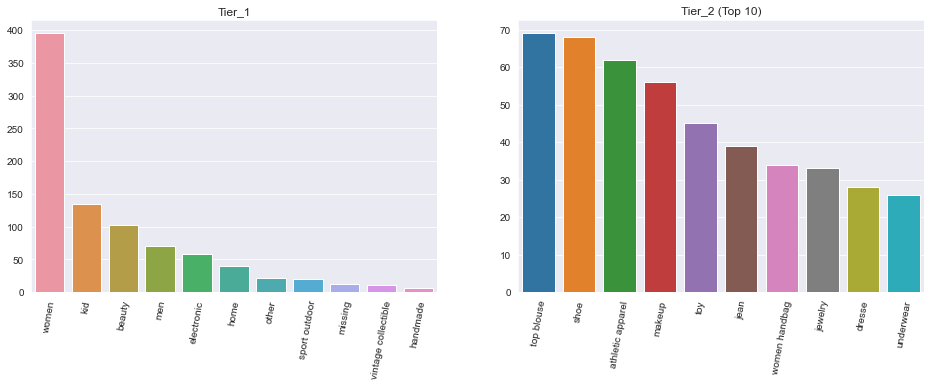

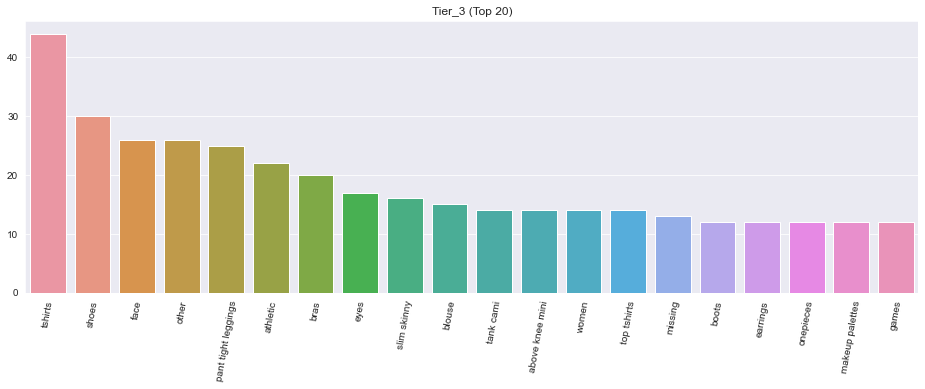

In [55]:
'''PLOTTING THE BAR PLOT FOR THE CATEGORY IN TIER1 TIER2 TIER3'''
plt.figure(figsize= (16,5))
plt.subplot(1,2,1)
sns.barplot(x = zero_price.Tier_1.value_counts().index,y = zero_price.Tier_1.value_counts().values)
plt.xticks(rotation= 80)
plt.title("Tier_1")

plt.subplot(1,2,2)
sns.barplot(x = zero_price.Tier_2.value_counts().index[:10],y = zero_price.Tier_2.value_counts().values[:10])
plt.xticks(rotation= 80)
plt.title("Tier_2 (Top 10)")
plt.show()

plt.figure(figsize=(16,5))
sns.barplot(x = zero_price.Tier_3.value_counts().index[:20],y = zero_price.Tier_3.value_counts().values[:20])
plt.xticks(rotation= 80)
plt.title("Tier_3 (Top 20)")
plt.show()

**Obsevation:**

Most of the products which are at price "0" are clothing or bueaty products which falls under women category.

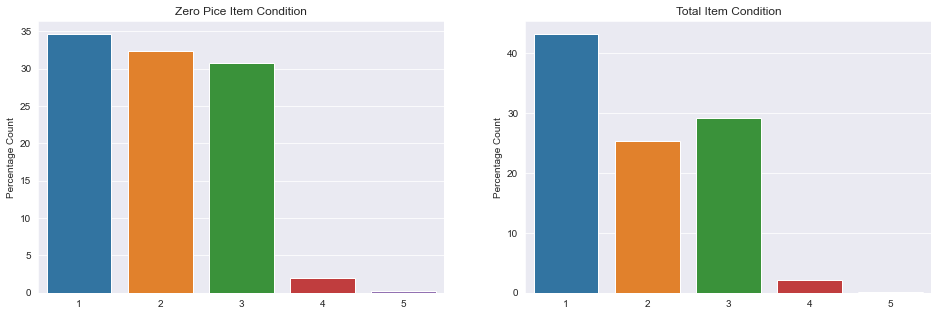

In [56]:
'''COMPATISON BETWEEN DATAPOINTS WITH ZERO PRICE AND OVERALL DATA FOR PRECENTAGE OF COMPONENTS IN EACH ITEM CONDITIONS '''
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.barplot(x=zero_price.item_condition_id.value_counts().index,y = zero_price.item_condition_id.value_counts().values/zero_price.shape[0]*100)
plt.title("Zero Pice Item Condition")
plt.ylabel("Percentage Count")

plt.subplot(1,2,2)
sns.barplot(x=df.item_condition_id.value_counts().index,y = df.item_condition_id.value_counts().values/df.shape[0]*100)
plt.title("Total Item Condition")
plt.ylabel("Percentage Count")
plt.show()

**Observation:**

- The products of zero price have higher percentage of products with item condition 2,3,4,5. This shows that the there may be the used items like clothings etc that people are giving out for free just for donation.
- This could also be due to some error in the entry.

In [57]:
# STORING THE CSV FILE 
df.to_csv("train_processed.csv")

In [58]:
# STORING THE CSV FILE 
df_test.to_csv("test_processed.csv")